## Connectome embedding alignment
Independent fitting iterations of the node2vec algorithm results in sets of vectors with similar cosine angle between each node pairs, but not necessarily similar absolute values (Dev et al., 2019). Here we demonstrate our novel approach which enables us to align separately learned CE to the same latent space. Given two independently trained models applied on the same connectome with latent embedding spaces *a* and *b* we want to transform the latent representation of node *i* from space *a* to *b*. 


<img src="https://raw.githubusercontent.com/GidLev/cepy/master/examples/ce_alignment.png" alt="CE alignment"  width = 542 height = 283/>



First, lets import some relevant packages:

In [1]:
%%capture
!pip install cepy
!pip install seaborn
!pip install -U scikit-learn
%matplotlib inline
import cepy as ce
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity, paired_cosine_distances


And download the structural connectivity data:

In [2]:
%%capture

# Structural connectivity matrix
!wget -O sub1_sc_matrix.npz 'https://github.com/GidLev/cepy/blob/master/examples/sub1_sc_matrix.npz?raw=true';
sc_mat = np.load('sub1_sc_matrix.npz')['x']

# Group consensus structural connectivity matrix
!wget -O group_sc_matrix.npz 'https://github.com/GidLev/cepy/blob/master/examples/group_sc_matrix.npz?raw=true';
group_sc_mat = np.load('group_sc_matrix.npz')['x']

Now let's fit two CE models on the same subject (this should take ~ 5 minutes):

In [3]:
# setting the hyper parameters
embedding_dimensions = 30

# initiate the CE mod   el
ce_a = ce.CE(dimensions=embedding_dimensions, walk_length=20, num_walks=600, 
             p=0.1, q=1.6, window = 3, permutations  = 1, seed = 1)
ce_b = ce.CE(dimensions=embedding_dimensions, walk_length=20, num_walks=600, 
             p=0.1, q=1.6, window = 3, permutations  = 1, seed = 1)

# Sample walks and fit the CE models
ce_a.fit(sc_mat)
ce_b.fit(sc_mat)

/usr/local/lib/python3.6/dist-packages/cepy/ce.py:109: UserWarning: num_walks is recommended to be at least 800, but is 600.
  warnings.warn('num_walks is recommended to be at least 800, but is ' + str(num_walks) + '.')


Start training  1  word2vec models on  1 threads.
Start training  1  word2vec models on  1 threads.


In each of the models, a separate  *W’* transformation was learned, *W’<sub>a</sub>* and *W’<sub>b</sub>*, respectively. Will start by deriving the embedding of node *i* in space *a* by multiplying the one-hot encoding of all node, *V<sup>input</sup>*, with *W<sub>a</sub>*. Note that the subscript denotes the  source and current latent space.

$$ v_{a,a}^{embedd}=W_a^\intercal\cdot V^{input} $$

The *V<sup>input</sup>* matrix in our case is simply the identity matrix since it is an ordered one-hot representation of all nodes, hence:

$$ v_{a,a}^{embedd}=W_a^\intercal $$

In the *W* matrix row *i* is the embedding vector of node *i*.

We can extract the *W* and *W’* matrices from the fitted models:

In [4]:
# get W and W' for embedding iteration a
W_a = ce_a.weights.get_w_permut(norm = False)
W_apos_a = ce_a.weights.get_w_apos_permut(norm = False)

# get W and W' for embedding iteration b
W_b = ce_b.weights.get_w_permut(norm = False)
W_apos_b = ce_b.weights.get_w_apos_permut(norm = False)

Now let's examine the cosine similarity among each node pair in subject a and subject b:

In [5]:
cosine_matrix_a = cosine_similarity(W_a)
cosine_matrix_b = cosine_similarity(W_b)

To examine how consistant these similarities across independent fitting iterations we can compute the correlation between the two:

Pearson correlation coefficient: 0.980, p: 0.000.


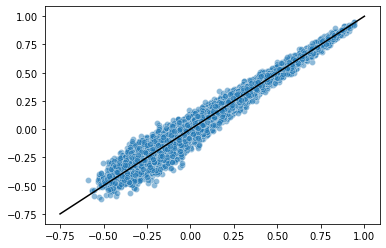

In [6]:
num_nodes = sc_mat.shape[0]

low_diag_mat_a = cosine_matrix_a[np.tril_indices(num_nodes, -1)]
low_diag_mat_b = cosine_matrix_b[np.tril_indices(num_nodes, -1)]

sns.scatterplot(x=low_diag_mat_a, y=low_diag_mat_b, alpha = 0.5)
plt.plot([-0.75,1], [-0.75,1], color='k')
r, p = stats.pearsonr(low_diag_mat_a, low_diag_mat_b)
print('Pearson correlation coefficient: {:.3f}, p: {:.3f}.'.format(r, p))

This should be high.

But, when we examine the similarity of pairs of identical nodes across the two sets of embeddings, this is not always the case:

The mean cosine similarity before alignment: 0.879


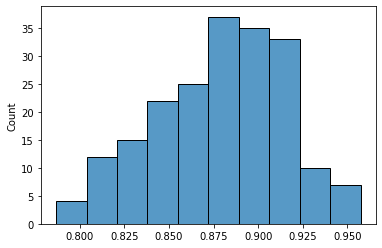

In [7]:
def paired_cosine_similarity(X,Y):
    '''Computes the paired cosine similarity (1 - distance) between X and Y'''
    return 1 - paired_cosine_distances(X,Y)

cosine_similarities = paired_cosine_similarity(W_b, W_a)
sns.histplot(cosine_similarities);
print('The mean cosine similarity before alignment: {:.3f}'.format(cosine_similarities.mean()))

Now we can examine how embedding alignment to a common space effects these measures. First let's train a CE model on a group consensus structural connectivity data that would be used as common reference space for alignment: 

In [8]:
# initiate the CE model
ce_group = ce.CE(dimensions=embedding_dimensions, walk_length=20, num_walks=800, 
                 p=0.1, q=1.6, window = 3, permutations  = 1, seed = 2021)

# Sample walks and fit the CE models
ce_group.fit(group_sc_mat)

# get W and W' for the group
W_group = ce_group.weights.get_w_permut(norm = False)
W_apos_group = ce_group.weights.get_w_apos_permut(norm = False)

Start training  1  word2vec models on  1 threads.


Alignment is done in two stages. First, the vector is multiplied with *W’<sub>a</sub>* to transform it to the node2vec model output representation:
$$ V_{a,a}^{output}= {W'}_a^{\intercal} \cdot V_{a,a}^{embedd} $$

Since the one-hot representational constraint exists in all fitting iterations, this output representation is similar across separately trained models. Stemming from this, we can apply the inverse of transformation *W’<sub>group</sub>*, to move to the group latent space. Since *W’* is non-square we apply the pseudo-inverse transformation *W’<sub>group</sub><sup>+</sup>*:

$$ V_{a,b}^{embedd}=W_b^{\prime+\intercal}\cdot V_{a,a}^{output} $$

In [9]:
W_a_to_output = np.dot(W_apos_a.T, W_a.T) # transform to the output space
transformation_to_group = np.linalg.pinv(W_apos_group).T # compute the inverse of the group's W'
W_a_to_group = np.dot(transformation_to_group,W_a_to_output).T # transform to the group latent space

These steps are also implemented in cepy:

In [10]:
ce_a_to_group = ce.align(ce_group, ce_a)
ce_b_to_group = ce.align(ce_group, ce_b)

W_a_to_group = ce_a_to_group.weights.get_w_permut(norm = False)
W_b_to_group = ce_b_to_group.weights.get_w_permut(norm = False)

Repeating the similarity test of pairs of identical nodes, this time in the aligned common space:



The mean cosine similarity after alignment: 0.963


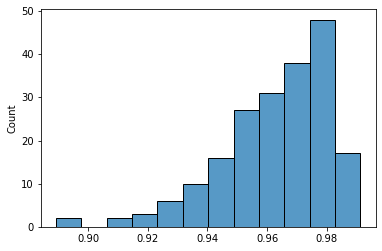

In [11]:
cosine_similarities = paired_cosine_similarity(W_b_to_group, W_a_to_group)
sns.histplot(cosine_similarities);
print('The mean cosine similarity after alignment: {:.3f}'.format(cosine_similarities.mean()))

Directly comparing the two:

Pair t-test: 29.564, p: 0.000.


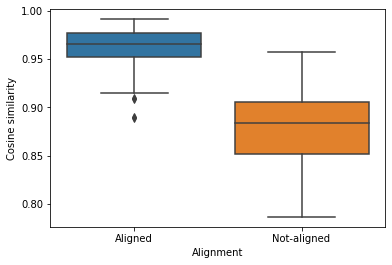

In [12]:
data = {'Cosine similarity': np.concatenate((paired_cosine_similarity(W_b_to_group, W_a_to_group), 
                                             paired_cosine_similarity(W_b, W_a))), 
        'Alignment': ['Aligned'] * num_nodes + ['Not-aligned'] * num_nodes}
data = pd.DataFrame(data=data)
sns.boxplot(x='Alignment', y='Cosine similarity', data=data)
t, p = stats.ttest_rel(data.loc[data['Alignment'] == 'Aligned', 'Cosine similarity'],
                       data.loc[data['Alignment'] == 'Not-aligned', 'Cosine similarity'])
print('Pair t-test: {:.3f}, p: {:.3f}.'.format(t, p))

Similarly, the cosine similarity matrix depicting all pair-wise embeddings cosine similarity could be computed for each fitting iteration in the new common space. Then, to examine the consistency of these pair-wise relation, we again compute the correlation between the two:

Pearson correlation coefficient: 0.981, p: 0.000.


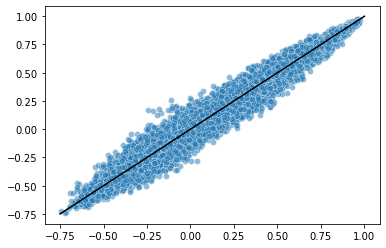

In [13]:
cosine_matrix_a = cosine_similarity(W_a_to_group)
cosine_matrix_b = cosine_similarity(W_b_to_group)

low_diag_mat_a = cosine_matrix_a[np.tril_indices(num_nodes, -1)]
low_diag_mat_b = cosine_matrix_b[np.tril_indices(num_nodes, -1)]

sns.scatterplot(x=low_diag_mat_a, y=low_diag_mat_b, alpha = 0.5)
plt.plot([-0.75,1], [-0.75,1], color='k')
r, p = stats.pearsonr(low_diag_mat_a, low_diag_mat_b)
print('Pearson correlation coefficient: {:.3f}, p: {:.3f}.'.format(r, p))

This should remain relatively high.

### references

* Dev, S., Hassan, S., & Phillips, J. M. (2019). Closed form word embedding alignment. In Proceedings - IEEE International Conference on Data Mining, ICDM (Vol. 2019-November, pp. 130–139). Institute of Electrical and Electronics Engineers Inc. https://doi.org/10.1109/ICDM.2019.00023
